### Autoencoder training to learn decoupling coordinates of Series Elastic Actuator

Consider a series elastic actuator with motor inertia $I_0$, link inertia $I_1$ and spring stiffness $k$. <br>The (actuated) motor angle $\theta_0$ and (unactuated) link angle $\theta_1$ are linked through the spring. <br>This standard formulation results in an inertially and input decoupled system in Euler-Lagrange formulation:

$\mathbf{M} \ddot{\theta} + \mathbf{G}(\theta) = \mathbf{A} u$

With mass matrix:

$\mathbf{M}(\theta) = \begin{bmatrix} I_0 & 0 \\\ 0 & I_1 \end{bmatrix}$

potential matrix:

$\mathbf{G}(\theta) = \begin{bmatrix} \phantom{-.} k (\theta_0 - \theta_1)\\\ -k (\theta_0 - \theta_1)\end{bmatrix}$ 

and input matrix:

$\mathbf{A}(\theta) = \begin{bmatrix} 1 \\\ 0 \end{bmatrix}$

### Relative angles
When instead one chooses as second coordinate the relative angle, the system is no longer inertially decoupled.<br>Choose:<br>$q_0 = \theta_0$ (motor angle)<br>$q_1 = \theta_1 - \theta_0$ (relative angle)

This result in the following Euler-Lagrange formulation:

Kinetic energy:

$T = \frac{1}{2} I_0 \dot{q}_0^2 + \frac{1}{2} I_1 (\dot{q}_1+\dot{q}_0)^2$

Potential energy:

$V = \frac{1}{2} k q_1^2$

Lagrangian L = T - V:

$L = \frac{1}{2} I_0 \dot{q}_0^2 + \frac{1}{2} I_1 (\dot{q}_1+\dot{q}_0)^2 - \frac{1}{2} k q_1^2$

We know that we must have:<br>
$\frac{d}{dt}(\frac{\partial L}{\partial \dot{\theta_i}}) - \frac{\partial L}{\partial \theta_i} = 0$

With partial derivatives:<br>
$\frac{d}{dt}(\frac{\partial L}{\partial \dot{\theta_0}}) = (I_0 + I_1) \ddot{q}_0 + I_1 \ddot{q}_1$, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\frac{\partial L}{\partial \theta_0} = 0$

$\frac{d}{dt}(\frac{\partial L}{\partial \dot{\theta_1}}) = I_1 \ddot{q}_0 + I_1 \ddot{q}_1$, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\frac{\partial L}{\partial \theta_1} = k \theta_1$

Leading to the following matrices:

$\mathbf{M}(q) = \begin{bmatrix} I_0 + I_1 & I_1 \\\ I_1 & I_1 \end{bmatrix}$

$\mathbf{G}(q) = \begin{bmatrix} 0\\\ k q_1\end{bmatrix}$ 

$\mathbf{A}(q) = \begin{bmatrix} 1 \\\ 0 \end{bmatrix}$


### So what should the autoencoder learn?

Starting with the "naive" coordinates $q$, the only choice of coordinates that leads to inertial and input decoupling is $\theta$, or some trivial re-scaling of $\theta$. 

The autoencoder is thus trying to approximate:

$\begin{bmatrix} \theta_0 \\ \theta_1 \end{bmatrix} = \begin{bmatrix} q_0 \\ q_0 + q_1 \end{bmatrix}$

With Jacobian:

$J_h(q) = \begin{bmatrix} 1 & 0 \\ 1 & 1 \end{bmatrix}$

### Let's go (starting with imports)

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("../.."))

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import matplotlib.pyplot as plt

from datetime import datetime
import time
import json

import Series_Elastic_Actuator.robot_parameters_SEA as robot_parameters_SEA
import Series_Elastic_Actuator.transforms_SEA as transforms_SEA
import Series_Elastic_Actuator.dynamics_SEA as dynamics_SEA

import Series_Elastic_Actuator.Learning.training_data_SEA as training_data_SEA
import Plotting.theta_visualiser as theta_visualizer

import Series_Elastic_Actuator.Learning.autoencoders_SEA as autoencoders_SEA

from functools import partial

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters_SEA.SEA_PARAMETERS
print(rp)

cuda
{'I0': 2.0, 'I1': 3.0, 'k': 0.3}


In [4]:
# Create points (q0, q1) between -pi and pi for training
points = training_data_SEA.points.to(device)

In [5]:
def points_plotter(points, extend = None, save = False, file_path = None):

	""" 
	Simple plotter function which visualizes the points used for training of the Autoencoder. 
	"""
	 
	plt.figure(figsize=(6, 6))
	plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
	plt.title('Scatter Plot of q0 vs q1')
	plt.xlabel('q0')
	plt.ylabel('q1')
	plt.xlim(-2*torch.pi, 2*torch.pi)
	plt.ylim(-2*torch.pi, 2*torch.pi)
	plt.grid(True)
	
	if save:
		plt.savefig(file_path, dpi=800)
	plt.show()

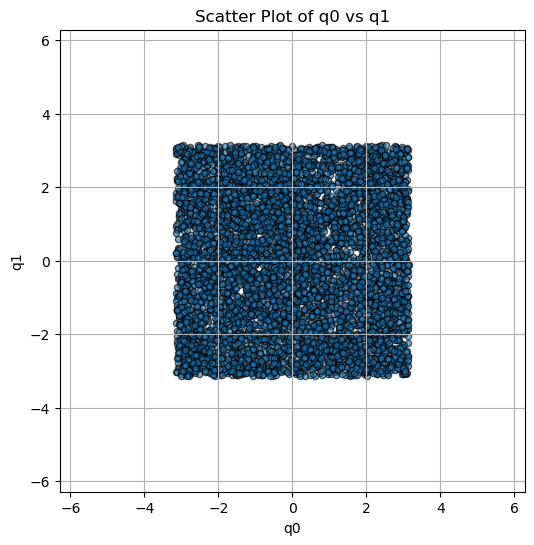

In [6]:
points_plotter(points)

In [7]:
def make_dataset(points):

	"""
	Compute mass- and input matrix of all training points to reduce load in training.
	Returns TensorDataset of (q, M_q, A_q). 
	"""
	
	data_pairs = []
	for point in points:
		Mq_point, _ = dynamics_SEA.dynamical_matrices(rp, point, point)
		Aq_point = dynamics_SEA.input_matrix()
		data_pairs.append((point, Mq_point, Aq_point))

	points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
	mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
	input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

	# Create TensorDataset
	dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
	return(dataset)


In [8]:
def make_dataloaders(dataset, batch_size = 512, train_part = 0.7):

	"""
	Creates a training and validation dataloader from an input dataset, based on 
	batch size and the ratio train_part. 
	"""

	train_size = int(train_part * len(dataset))
	val_size = len(dataset) - train_size

	# Create TensorDataset for both training and testing sets
	train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

	# Create the DataLoader for both training and testing sets
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
	val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

	return(train_dataloader, val_dataloader)

In [9]:
import torch.nn.functional as F

# Need to pick weights through some optimization scheme
w_recon			= 4.
w_diag			= 1.25
w_off_diag		= 1.25
w_input 		= 1.
w_input_jac		= 0.8
w_theta			= 1.
w_J_eye 		= 1.


def loss_fun(q, theta, q_hat, M_q, A_q, J_h_enc, J_h_dec):

	"""
	Loss function for training the Autoencoder. Loss terms are the following:
	l_recon:    	Loss between input- and reconstructed variable. (MSE)
	l_diag:      	Loss on diagonal terms of mass matrix in theta-space. 
					(mean of normalized negative log-loss)
	l_off_dia:  	Loss of off-diagonal terms of mass matrix in theta-space. (MSE)
	l_input:    	Loss to drive input matrix in theta-space to [1, 0]^T (MSE)
	l_input_jac:	Loss based on 1st Jacobian row similarity to A_q column
	l_theta: 		Loss on the first coordinate theta_0, based on analytic knowledge
	l_J_eye: 		Loss on J_enc@J_dec similarity to identity
	"""

	

	# Calculate forward and inverse Jacobians
	J_h = J_h_enc
	J_h_trans = torch.transpose(J_h, 1, 2)
	J_h_inv = J_h_dec
	J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

	M_th = J_h_inv_trans @ M_q @ J_h_inv
	A_th = J_h_inv_trans @ A_q

	# 1. Standard reconstruction loss
	delta = torch.atan2(torch.sin(q-q_hat), torch.cos(q-q_hat))
	l_recon = F.mse_loss(delta, torch.zeros_like(delta), reduction="mean")

	# 2. Inertial decoupling, diagonal
	diag_values = torch.diagonal(M_th, dim1=1, dim2=2)
	l_diag = torch.mean((-1 + torch.exp(-(diag_values - 1))) * (diag_values < 1).float())  # Shape: (batch_size, 2)

	# 3. Inertial decoupling, off-diagonal
	l_off_diag = torch.mean((M_th[:, 0, 1])**2)

	# 4. Input decoupling
	l_input = torch.mean((A_th[:, 1]**2))

	# 5. Jacobian loss, inspired by Pietro Pustina's paper on input decoupling: # https://arxiv.org/pdf/2306.07258
	l_input_jac = F.mse_loss(J_h[:, 0, :], A_q[:, :, 0], reduction="mean")

	# 6. On the first coordinate theta, again from Pietro Pustina's analytic formulation
	theta_ana = torch.vmap(transforms_SEA.analytic_theta, in_dims = (None, 0))(rp, q)
	l_theta = F.mse_loss(theta[:, 0], theta_ana[:, 0], reduction="mean")

	# 7. Jacobian identity loss
	l_J_eye = F.mse_loss( torch.bmm(J_h, J_h_inv), 
						torch.eye(2,device=J_h.device).unsqueeze(0).repeat(J_h.size(0),1,1),
						reduction='mean' )


	
	"""
	# ALTERNATIVE LOSS: For inertial decoupling, error w.r.t. identity matrix. 
	#print(torch.eye(M_th.size(-1)))]).
	M_eye = torch.eye(M_th.size(-1), device=M_th.device, dtype=M_th.dtype).expand(M_th.size())
	l_inertia_eye = F.mse_loss(M_th, M_eye, reduction="mean")
	"""

	loss_terms = torch.tensor([l_recon * w_recon, l_diag * w_diag, l_off_diag * w_off_diag, 
	                           l_input * w_input, l_input_jac * w_input_jac, l_theta * w_theta,  l_J_eye * w_J_eye])
	loss_sum = (l_recon * w_recon + l_diag * w_diag + l_off_diag * w_off_diag + l_input * w_input + 
				l_input_jac * w_input_jac + l_theta * w_theta + l_J_eye * w_J_eye)

	return loss_sum, loss_terms

In [10]:
def train_AE_model(rp, device, lr, num_epochs, q0_split, train_dataloader, val_dataloader, current_time, dir_name = None):

	"""
	Executes training loop for Autoencoder
	"""

	# Very big fluff to make folders and save paths
	if dir_name is None:
		model = autoencoders_SEA.Autoencoder_double(rp).to(device)  # Move model to GPU
		dir_name = f"NN_{current_time}"
		file_counter = 0
	else:
		dir_path = os.path.join(os.getcwd(), "Models", dir_name)
		nn_filename = dir_name + "_0.pth"
		nn_filepath = os.path.join(dir_path, nn_filename)
		file_counter = 0
		while os.path.isfile(nn_filepath):
			print("Looking for latest weights and bias file.")
			file_counter += 1
			nn_filename = nn_filename[:-6] + "_" + str(file_counter) + ".pth"
			nn_filepath = os.path.join(dir_path, nn_filename)

		model_path = os.path.join("Models", dir_name, dir_name + "_" + str(file_counter-1) + ".pth")
		model = autoencoders_SEA.Autoencoder_double(rp).to(device)  # Initialize model architecture
		model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))  # Load weights

	optimizer = torch.optim.Adam(model.parameters(), lr=lr)#,  weight_decay=1e-6)
	scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))

	start_time = time.time()       
	dir_path = os.path.join(os.getcwd(), "Models", dir_name)
	os.makedirs(dir_path, exist_ok=True)
	nn_filename = dir_name + "_" + str(file_counter) + ".pth"
	nn_filepath = os.path.join(dir_path, nn_filename)

	metadata = {"q0_low" : q0_split[0],
				"q0_high" : q0_split[1],
				"lr" : lr,
				"epochs" : num_epochs,
				"file_name" : nn_filename,
				"loss_weights": {
					"w_recon": w_recon,
					"w_diag": w_diag,
					"w_off_diag": w_off_diag,
					"w_input": w_input,
					"w_input_jac": w_input_jac,
					"w_theta": w_theta,
					"w_J_eye": w_J_eye
				}}
	metadata["architecture"] = {
    "encoder": autoencoders_SEA.summarize_sequential(model.enc),
    "decoder": autoencoders_SEA.summarize_sequential(model.dec)
	}
	
	metadata_filename = "metadata_" + str(file_counter) + ".json"
	metadata_filepath = os.path.join(dir_path, metadata_filename)
	with open(metadata_filepath, "w") as f:
		json.dump(metadata, f, indent=4)

	# Initialise training parameters
	train_losses = []
	val_losses = []

	for epoch in range(num_epochs):

		# Training phase
		model.train()
		train_loss = 0
		train_loss_terms = torch.zeros(7)
		for index, (q, M_q, A_q) in enumerate(train_dataloader):
			q = q.to(device)
			M_q = M_q.to(device)
			A_q = A_q.to(device)

			batch_size = q.size(0)
			
			theta, J_h, q_hat, J_h_dec, J_h_ana = model.forward(q)  
			theta_ana = model.theta_ana(q)
					
			loss, loss_terms = loss_fun(q, theta, q_hat, M_q, A_q, J_h, J_h_dec)
			
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			
			train_loss += loss.item() * batch_size
			train_loss_terms += loss_terms * batch_size
		train_loss /= len(train_dataloader.dataset) 
		train_loss_terms /= len(train_dataloader.dataset) 
		train_losses.append(train_loss)

		# Validation phase
		model.eval()
		val_loss = 0
		val_loss_terms = torch.zeros(7)
		with torch.no_grad():
			for index, (q, M_q, A_q) in enumerate(val_dataloader):
				q = q.to(device)
				M_q = M_q.to(device)
				A_q = A_q.to(device)

				batch_size = q.size(0)

				theta, J_h, q_hat, J_h_dec, J_h_ana = model.forward(q)
				theta_ana = model.theta_ana(q)

				loss, loss_terms = loss_fun(q, theta, q_hat, M_q, A_q, J_h, J_h_dec)

				val_loss += loss.item() * batch_size
				val_loss_terms += loss_terms * batch_size
		val_loss /= len(val_dataloader.dataset)
		val_loss_terms /= len(val_dataloader.dataset)
		val_losses.append(val_loss)
		epoch_duration = time.time() - start_time
		scheduler.step()


		# Print results every epoch
		tlt = train_loss_terms
		print(
			f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds')
		print(
		    f'l_recon: {tlt[0]:.4f}, l_diag: {tlt[1]:.4f}, l_off_diag: {tlt[2]:.4f}, l_input: {tlt[3]:.4f}, l_input_jac: {tlt[4]:.4f}, l_theta: {tlt[5]:.4f}')
		#print(
		#	f'l_recon: {tlt[0]:.4f}, l_inertia: {tlt[1]:.4f}, l_input: {tlt[2]:.4f}, l_input_jac: {tlt[3]:.4f}, l_theta: {tlt[4]:.4f}')
		
	return(model, train_losses, val_losses, dir_path, nn_filepath, file_counter)


In [11]:
def save_model(model, file_path):
	torch.save(model.state_dict(), file_path)
	print(f"Model parameters saved to {file_path}")


In [12]:
def plot_loss(train_losses, val_losses, log = False, save = False, file_path = None):

	"""
	Plots training and validation loss. 
	ylim" and "yscale" should be enabled depending on the loss function.
	"""

	plt.figure(figsize=(10, 6))
	plt.plot(train_losses, label="Training Loss")
	plt.plot(val_losses, label="Validation Loss")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	#plt.ylim((-1, 40))
	plt.legend()
	plt.title("Training and Validation Loss over Epochs")
	plt.grid(True)
	if log:
		plt.yscale("log")
	if save:
		plt.savefig(file_path, dpi=800)
	plt.show()


In [13]:
import Plotting.plotters_simple as plotters_simple

def make_plot_dataloader(dataset, stride = 1):

	"""
	Takes the training dataset and returns a dataloader of every 10th point
	to reduce visual clutter. 
	"""

	points_tensor, mass_matrices_tensor, input_matrices_tensor = dataset.tensors
	
	plot_sampled = points_tensor[::stride]
	mass_sampled = mass_matrices_tensor[::stride]
	input_sampled = input_matrices_tensor[::stride]

	plot_dataset = TensorDataset(plot_sampled, mass_sampled, input_sampled)
	plot_dataloader = DataLoader(plot_dataset, batch_size=len(plot_dataset), shuffle=False, num_workers=0)

	return(plot_dataloader)

In [ ]:
def plot_model_performance(model, plot_dataloader, save_folder, device):

	os.makedirs(save_folder, exist_ok=True)

	model.eval()
	with torch.no_grad():
		for (q, M_q, A_q) in plot_dataloader:
			q = q.to(device)
			M_q = M_q.to(device)
			A_q = A_q.to(device)

			theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
			theta_ana = model.theta_ana(q)
			J_h_trans = torch.transpose(J_h, 1, 2)
			J_h_inv = J_h_dec
			J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

			J_h_inv_ana = torch.linalg.inv(J_h_ana)
			J_h_inv_trans_ana = torch.transpose(J_h_inv_ana, 1, 2)

			M_th = J_h_inv_trans @ M_q @ J_h_inv
			A_th = (J_h_inv_trans @ A_q).squeeze(-1)

			M_th_ana = J_h_inv_trans_ana @ M_q @ J_h_inv_ana
			A_th_ana = (J_h_inv_trans_ana @ A_q).squeeze(-1)

			J_h_eye = torch.bmm(J_h, J_h_inv)
			J_h_eye_error = J_h_eye - torch.eye(2).to(device)
			J_norm = torch.norm(J_h_eye_error, "fro", dim=(1,2))

			A_th_target = torch.tensor([[1.,0.]]).repeat(A_th.size(0), 1).to(device)
			A_th_norm = torch.norm(A_th - A_th_target, "fro", dim=(1))

			M_th_clamped = torch.clamp(M_th, max = 1.)
			M_th_target = torch.eye(2).unsqueeze(0).expand(M_th.size(0), -1, -1).to(device)
			M_th_norm = torch.norm(M_th_clamped - M_th_target, "fro", dim=(1,2))

			q_norm = torch.norm(q - q_hat, dim=1)


			print("A_th_target size:", A_th_target.size())
			print("A_th_norm size:", A_th_norm.size())


			A_th_cpu = A_th.cpu().detach().numpy()
			print("Percentage of abs(A_0) > 0.8:", 100 * np.sum(np.abs(A_th_cpu[:, 0]) > 0.8)/A_th_cpu[:, 0].size, "%")
			print("Percentage of abs(A_1) < 0.2:", 100 * np.sum(np.abs(A_th_cpu[:, 1]) < 0.2)/A_th_cpu[:, 1].size, "%")
			
			
			M_th_cpu = M_th.cpu().detach().numpy()
			print("Percentage of abs(M_00) > 1.0:", 100 * np.sum(np.abs(M_th_cpu[:, 0, 0]) > 1.0)/M_th_cpu[:, 0, 0].size, "%")
			print("Percentage of abs(M_01) < 0.1:", 100 * np.sum(np.abs(M_th_cpu[:, 0, 1]) < 0.1)/M_th_cpu[:, 0, 1].size, "%")
			print("Percentage of abs(M_11) > 1.0:", 100 * np.sum(np.abs(M_th_cpu[:, 1, 1]) > 1.0)/M_th_cpu[:, 1, 1].size, "%")

			plotting_2d = True

			
			if plotting_2d:
				plotters_simple.plot_2d_single(q, J_norm, "J identity norm terms", "Jacobian identity error", r"$q_0$" + " " + r"$(rad)$", r"$q_1$" + " " + r"$(rad)$", r"$\|J_{enc}J_{dec} - I\|_F$" + "   " + r"$(-)$", save_folder)
				plotters_simple.plot_2d_single(q, A_th_norm, "A_th norm terms", r"$A_{\theta}(\theta)$" + " error", r"$q_0$" + " " + r"$(rad)$", r"$q_1$" + " " + r"$(rad)$", r"$\|A_{\theta} - [1, 0]^T\|_F$" + "   " + r"$(m)$", save_folder)
				plotters_simple.plot_2d_single(q, M_th_norm, "M_th norm terms", r"$M_{\theta}(\theta)$" + " error", r"$q_0$" + " " + r"$(rad)$", r"$q_1$" + " " + r"$(rad)$", r"$\|M_{\theta} - I_1\|_F$" + "   " + r"$(kg m^2)$", save_folder)
				plotters_simple.plot_2d_single(q, q_norm, "q norm terms", r"$q$" + " reconstruction error", r"$q_0$" + " " + r"$(rad)$", r"$q_1$" + " " + r"$(rad)$", r"$\|\hat{q} - q\|_2$" + "   " + r"$(rad)$", save_folder)
				plotters_simple.plot_2d_quad(q, [theta_ana[:, 0], theta_ana[:, 1], theta[:, 0], theta[:, 1]], "theta vs q q-space", 
								 			[r"$\theta_{a}$" + " - analytic" + " " + r"$(m)$", r"$\theta_{u}$" + " - analytic" + " " + r"$(rad)$", r"$\theta_{a}$" + " - learned" + " " + r"$(m)$", r"$\theta_{u}$" + " - learned" + " " + r"$(rad)$"], r"$q_{0}$" + " " + r"$(rad)$", r"$q_{1}$" + " " + r"$(rad)$", None, save_folder)


				

In [ ]:
q1_split = (-torch.pi, torch.pi)
batch_size = 512
train_part = 0.7

num_epochs = 3001
lr = 1e-3

# IMPORTANT:
# If you want to train on an existing model
#existing_model_name = "NN_202503231956"
existing_model_name = "NN_202506181658"

#plt.ion()

current_time = datetime.now().strftime("%Y%m%d%H%M")

dataset = make_dataset(points)
(train_dataloader, val_dataloader) = make_dataloaders(dataset=dataset, batch_size=batch_size, train_part=train_part)
outputs = []
model, train_losses, val_losses, dir_path, nn_filepath, file_counter = train_AE_model(rp, device, lr, num_epochs, q1_split, train_dataloader, 
														val_dataloader, current_time, existing_model_name)

In [15]:
model_path = os.path.join("Models", "NN_small_good", "NN_202506181658_0" + ".pth")
model = autoencoders_SEA.Autoencoder_double(rp).to(device)  # Initialize model architecture
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))  # Load weights

<All keys matched successfully>

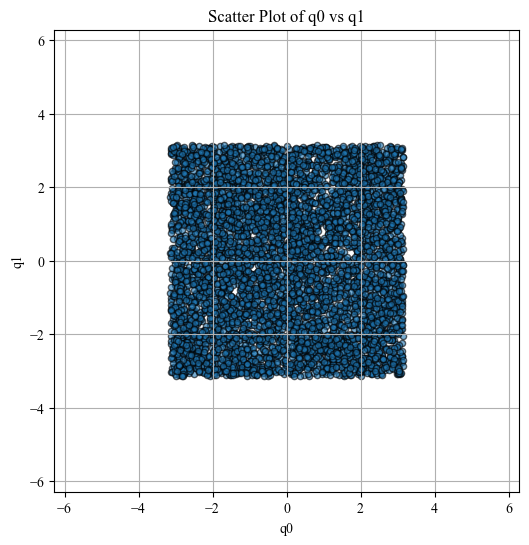

In [16]:
existing_model_name = "NN_small_good"
file_counter = 0
dir_name = existing_model_name
dir_path = os.path.join(os.getcwd(), "Models", dir_name)
points_path = os.path.join(dir_path, "training_points_" + str(file_counter) + ".png")
points_plotter(points, save = True, file_path = points_path)
scatter_fig_path = os.path.join(dir_path, "loss_" + str(file_counter) + ".png")
#plot_loss(train_losses, val_losses, log = True, save = True, file_path = scatter_fig_path)
#save_model(model, nn_filepath)

q: torch.Size([2500, 2])
theta: torch.Size([2500, 2])


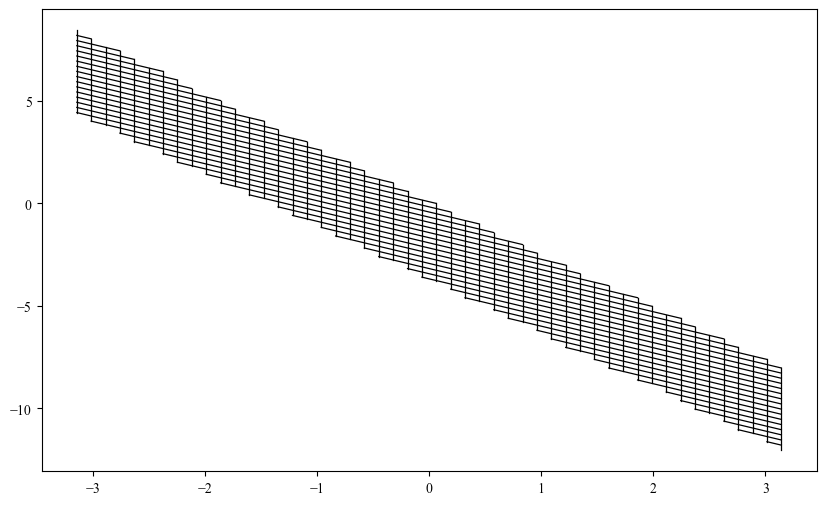

In [17]:
q1_split = (-torch.pi, torch.pi)
def theta_1_single(model, q):
	print("q:", q.size())
	theta = model.encoder(q)
	print("theta:", theta.size())
	return theta[:, 0].detach()
	
def theta_2_single(model, q):
	theta = model.encoder(q)
	return theta[:, 1].detach()
	
def q_hat_1_single(model, theta):
	q_hat = model.decoder(theta)
	return q_hat[:, 0].detach()
	
def q_hat_2_single(model, theta):
	q_hat = model.decoder(theta)
	return q_hat[:, 1].detach()

mapping_functions = (partial(theta_1_single,model), 
						partial(theta_2_single,model), 
						partial(q_hat_1_single,model), 
						partial(q_hat_2_single,model))
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, device=device, 
											mapping_functions=mapping_functions, mask_split=q1_split)
theta_figure_path = os.path.join(dir_path, "theta_mapping_" + str(file_counter) + ".png")
th_plotter.make_figure(theta_figure_path)
theta_anim_path = os.path.join(dir_path, "theta_mapping_" + str(file_counter) + ".mp4")
#th_plotter.make_animation(theta_anim_path, duration = 4, fps = 20)

A_th_target size: torch.Size([6000, 2])
A_th_norm size: torch.Size([6000])
Percentage of abs(A_0) > 0.8: 100.0 %
Percentage of abs(A_1) < 0.2: 100.0 %
Percentage of abs(M_00) > 1.0: 100.0 %
Percentage of abs(M_01) < 0.1: 100.0 %
Percentage of abs(M_11) > 1.0: 100.0 %


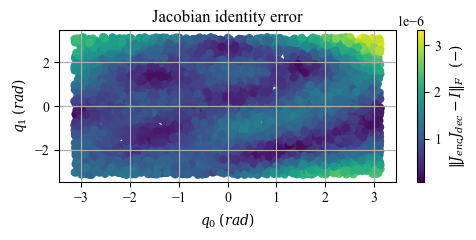

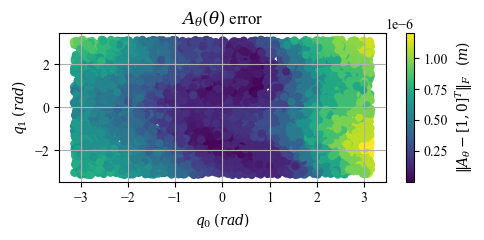

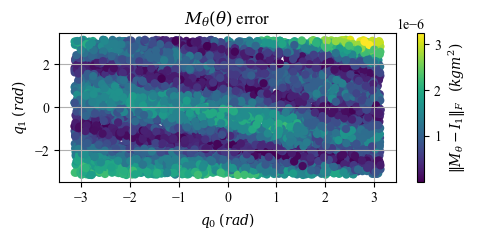

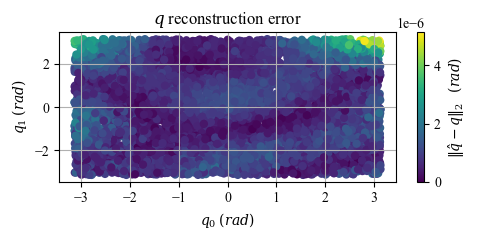

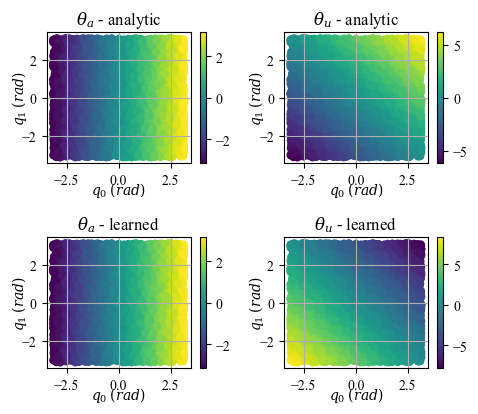

In [26]:
%matplotlib inline

folder_path = os.path.join(dir_path, "performance_plots_" + str(file_counter))

q1_split = (-torch.pi, torch.pi)
#plt.ion()
#model = autoencoders.Autoencoder_double(rp).to(device)
#model_location = 'Models/Split_AEs/Lumped_Mass_202503051257.pth'
#model.load_state_dict(torch.load(model_location, weights_only=True))
plot_points = points
plot_dataset = make_dataset(plot_points)
plot_dataloader = make_plot_dataloader(plot_dataset)
plot_model_performance(model, plot_dataloader, folder_path, device)
